In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 13.2 MB/s eta 0:00:00


In [ ]:
from keras.datasets import cifar10
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision import transforms
import torchvision
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision , BinaryRecall
from torch.optim.lr_scheduler import StepLR

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
model=nn.Sequential(
    nn.Linear(1024*3,2048*2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048*2,8192),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(8192,4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096,1024),
    nn.ReLU(),
    nn.Linear(1024,256),
    nn.ReLU(),
    nn.Linear(256,10)
)

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


Sequential(
  (0): Linear(in_features=3072, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=4096, out_features=8192, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=8192, out_features=4096, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=4096, out_features=1024, bias=True)
  (10): ReLU()
  (11): Linear(in_features=1024, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
sum(p.numel() for p in model.parameters())

84168458

In [ ]:
class myloader():
    def __init__(self, X,Y):
        self.X=X
        self.Y=Y
        transform_list = []
        transform_list += [transforms.ToTensor()]
        # transform_list += [transforms.RandomRotation(360)]
        # transform_list += [transforms.RandomHorizontalFlip(p=0.2)]
        # transform_list += [transforms.RandomVerticalFlip(p=0.2)]
        preprocess = transforms.Compose(transform_list)
        self.preprocess = preprocess
    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
      im=self.X[idx]
      # im=im.convert("RGB")
      im=self.preprocess(im)/255.0
      tar=torch.zeros((1,10))
      tar[0][int(self.Y[idx])]=1
      return im.view(1024*3,-1),tar

In [ ]:
train_loader = myloader(X_train,y_train)
test_loader = myloader(X_test,y_test)

train=torch.utils.data.DataLoader(train_loader,512,True)
test=torch.utils.data.DataLoader(test_loader,1024,False)

In [ ]:
optim=torch.optim.Adam(model.parameters(),lr=0.011)
n=25
loss_train = []
loss_test = []
test_acc=[]
metric0 = BinaryF1Score()
metric1 = BinaryAccuracy()
metric2 = BinaryPrecision()
scheduler = StepLR(optim, step_size=20, gamma=0.8)
cri=nn.CrossEntropyLoss()
cri.to(device)
cur_loss=10
m_los=10

In [ ]:
for epoch in range(n):
  model.train()
  los_test = []
  los_train = []
  f1_list = []
  acc_list = []
  pre_list = []
  for (x_tr, tar) in train:  
    x_tr = x_tr.to(device)
    tar = tar.to(device)
    tar=tar.squeeze(1)
    optim.zero_grad()
    out=model(x_tr.squeeze(2))
    loss = cri(out, tar)
    loss.backward()
    los_train.append(loss.item())
    optim.step()
  loss_train.append(sum(los_train)/len(los_train))

  model.eval()
  with torch.no_grad():
      for (x_tr, tar) in test:  
        x_tr = x_tr.to(device)
        tar = tar.to(device)
        tar=tar.squeeze(1)
        out=model(x_tr.squeeze(2))
        loss = cri(out, tar)
        los_test.append(loss.item())

      loss_test.append(sum(los_test)/len(los_test))

  print(f'epoch {epoch+1} train loss : {sum(los_train)/len(los_train)}')
  print(f'epoch {epoch+1} test loss : {sum(los_test)/len(los_test)}')

epoch 1 train loss : 5.711633903639657
epoch 1 test loss : 2.0543848037719727
epoch 2 train loss : 2.05450422909795
epoch 2 test loss : 2.0165959119796755
epoch 3 train loss : 2.013222713859714
epoch 3 test loss : 1.9394818067550659
epoch 4 train loss : 1.9458528598960565
epoch 4 test loss : 1.86606262922287
epoch 5 train loss : 1.920698061281321
epoch 5 test loss : 1.8886785507202148
epoch 6 train loss : 1.88995972336555
epoch 6 test loss : 1.831982707977295
epoch 7 train loss : 1.8751927577719396
epoch 7 test loss : 1.793322217464447
epoch 8 train loss : 1.8613382979315154
epoch 8 test loss : 1.811249589920044
epoch 9 train loss : 1.8477485411021175
epoch 9 test loss : 1.7621556162834167
epoch 10 train loss : 1.8358938134446436
epoch 10 test loss : 1.7706068277359008
epoch 11 train loss : 1.8310348014442288
epoch 11 test loss : 1.7610339999198914
epoch 12 train loss : 1.8234560854580937
epoch 12 test loss : 1.7365870475769043
epoch 13 train loss : 1.8176656900619974
epoch 13 test los

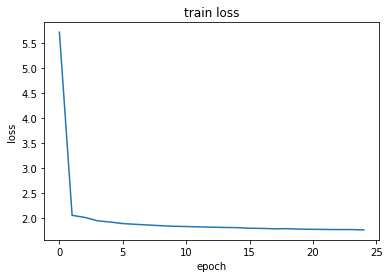

In [ ]:
plt.plot(loss_train)
plt.title("train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

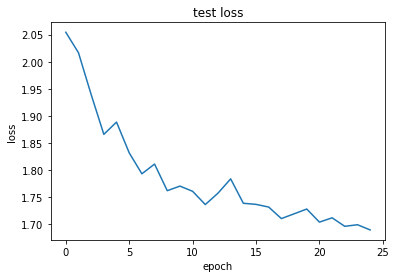

In [ ]:
plt.plot(loss_test)
plt.title("test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
metric1 = BinaryAccuracy()
metric2 = BinaryPrecision()

softmax = nn.Softmax(dim=1)

In [ ]:
torch.argmax(out)

tensor(6060, device='cuda:0')

In [ ]:
targets=[]
model_predicts=[]
losses=[]
model.eval() 
acc_list=[]
pre_list=[]
with torch.no_grad():
  for (x_tr, tar) in test:  
    x_tr = x_tr.to(device)
    tar = tar.to(device)
    tar=tar.squeeze(1)
    out=model(x_tr.squeeze(2))
    loss_t = cri(out, tar)
    losses.append(loss_t.item())
    out = softmax(out)
    acc_list.append(metric1(out.cpu(), tar.cpu()))
    pre_list.append(metric2(out.cpu(), tar.cpu()))
    targets.extend((torch.max(tar, 1)[1]).data.cpu().numpy())
    model_predicts.extend((torch.max(out, 1)[1]).data.cpu().numpy())

  print(f'test loss : {sum(losses)/len(losses)}')
  print(f'Acc : {sum(acc_list)/len(acc_list)}')
  print(f'Pre : {sum(pre_list)/len(pre_list)}')

test loss : 1.6898074388504027
Acc : 0.9044486284255981
Pre : 0.6841059923171997


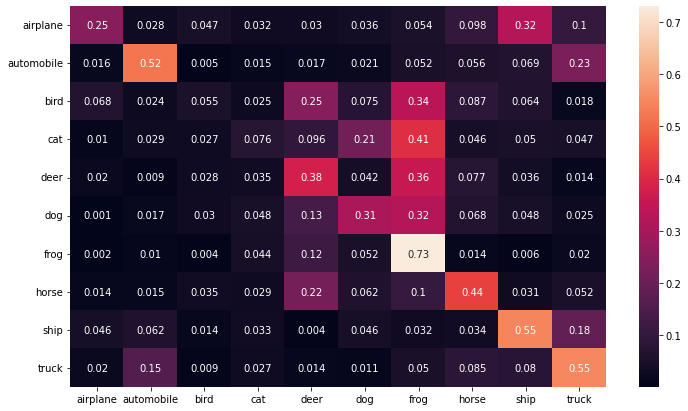

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
cf_matrix = confusion_matrix(targets, model_predicts)
classes=classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')